In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor


In [3]:

# Load dataset
file_path = 'DATA.xlsx'  # Replace with your dataset path
energy_df = pd.read_excel(file_path)

# # Preprocess 'YEARS' to extract the starting year
# data['Year'] = data['YEARS'].str.split('-').str[0].astype(int)
# data = data[['Year', 'Consumption']].sort_values(by='Year').reset_index(drop=True)

# Display the dataset
energy_df.head()




,YEARS,Consumption
0,1979-80,542254.0
1,1980-81,589017.0
2,1981-82,644907.0
3,1982-83,690214.0
4,1983-84,754725.0


In [4]:
# Convert 'YEARS' to datetime
def convert_years_to_datetime(year_str):
    start_year, end_year = year_str.split('-')
    start_year = int(start_year)
    end_year = int(end_year)
    return pd.to_datetime(f'{start_year}-01-01'), pd.to_datetime(f'{end_year}-12-31')

# Apply conversion function
energy_df['start_date'], energy_df['end_date'] = zip(*energy_df['YEARS'].map(convert_years_to_datetime))

# Set 'start_date' as the Date column
energy_df['date'] = energy_df['start_date']

# Drop 'start_date' and 'end_date' columns since we are using 'date'
energy_df = energy_df.drop(columns=['YEARS', 'start_date', 'end_date'])

# Extract temporal features from the 'date' column
energy_df['year'] = energy_df['date'].dt.year


In [5]:
energy_df.shape

(43, 3)

In [5]:
# Create lag features
energy_df['lag_1'] = energy_df['Consumption'].shift(1)
energy_df['lag_2'] = energy_df['Consumption'].shift(2)
energy_df['lag_3'] = energy_df['Consumption'].shift(3)

# Create rolling mean feature
energy_df['rolling_mean_3'] = energy_df['Consumption'].rolling(window=3).mean()

# Drop rows with missing values due to lag and rolling mean
energy_df = energy_df.dropna()


In [6]:
energy_df.head()

,Consumption,date,year,lag_1,lag_2,lag_3,rolling_mean_3
3,690214.0,1982-01-01,1982,644907.0,589017.0,542254.0,641379.333333
4,754725.0,1983-01-01,1983,690214.0,644907.0,589017.0,696615.333333
5,783807.0,1984-01-01,1984,754725.0,690214.0,644907.0,742915.333333
6,822735.0,1985-01-01,1985,783807.0,754725.0,690214.0,787089.000000
7,874255.0,1986-01-01,1986,822735.0,783807.0,754725.0,826932.333333


In [7]:
# Step 4: Prepare features (X) and target (y)
X = energy_df.drop(columns=['Consumption', 'date'])
y = energy_df['Consumption']


In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Train the model using XGBoost
model = XGBRegressor(n_estimators=500, early_stopping_rounds=10, learning_rate=0.05)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [14]:
# Make predictions
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')


Mean Absolute Error: 91619.00574631477


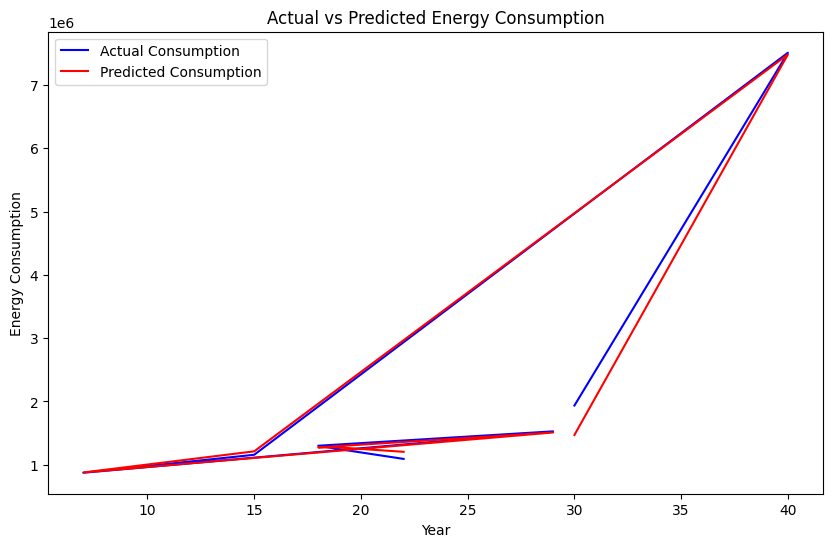

In [15]:
# Plot actual vs predicted consumption
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Consumption', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Consumption', color='red')
plt.xlabel('Year')
plt.ylabel('Energy Consumption')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()


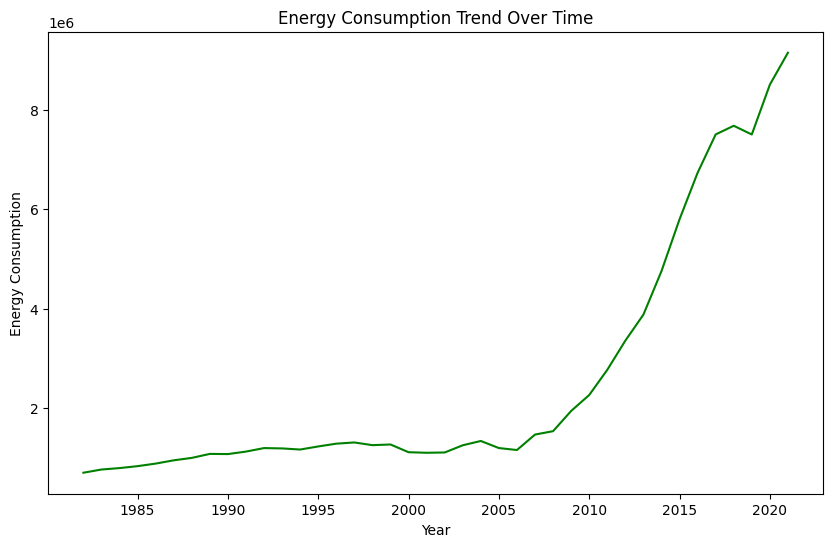

In [13]:
# Plot consumption trend over time
plt.figure(figsize=(10, 6))
plt.plot(energy_df['year'], energy_df['Consumption'], label='Energy Consumption', color='green')
plt.xlabel('Year')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption Trend Over Time')
plt.show()


In [14]:
from sklearn.metrics import r2_score

# Evaluate on the training data (you can also evaluate on the test data if you prefer)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate MAE and R² for train and test data
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# Display results
print(f"Training MAE: {mae_train}")
print(f"Test MAE: {mae_test}")
print(f"Training R²: {r2_train}")
print(f"Test R²: {r2_test}")


Training MAE: 94367.029296875
Test MAE: 91739.62293381477
Training R²: 0.9951343306356837
Test R²: 0.9935406975525519


In [15]:
# Generate a new 'future' dataset with the next 10 years
last_year = energy_df['year'].max()
future_years = np.arange(last_year + 1, last_year + 11)
future_df = pd.DataFrame({'year': future_years})

# Add the lag and rolling mean features for future years
# Assume the last known consumption value and apply the lag features
last_consumption = energy_df['Consumption'].iloc[-1]

# Create lagged features and rolling mean for future years
future_df['lag_1'] = [last_consumption] * 10
future_df['lag_2'] = [last_consumption] * 10
future_df['lag_3'] = [last_consumption] * 10
future_df['rolling_mean_3'] = [last_consumption] * 10  # Assuming rolling mean based on last value

# Prepare the features (X_future) for prediction

future_df.head()



,year,lag_1,lag_2,lag_3,rolling_mean_3
0,2022,9158934.0,9158934.0,9158934.0,9158934.0
1,2023,9158934.0,9158934.0,9158934.0,9158934.0
2,2024,9158934.0,9158934.0,9158934.0,9158934.0
3,2025,9158934.0,9158934.0,9158934.0,9158934.0
4,2026,9158934.0,9158934.0,9158934.0,9158934.0


In [16]:
# Predict future consumption
future_predictions = model.predict(future_df)

# Add the predicted values to the future_df DataFrame
future_df['predicted_consumption'] = future_predictions

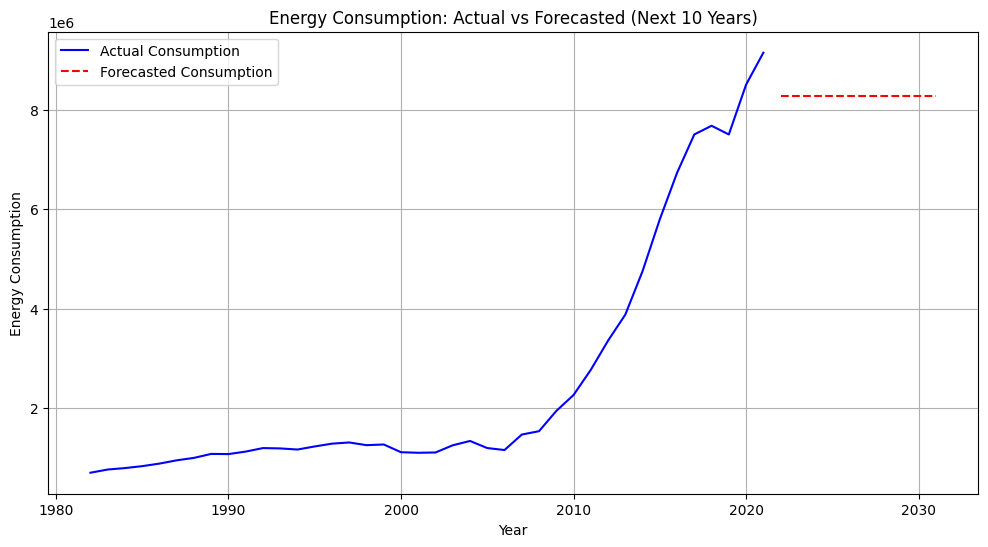

In [17]:
# Plot the forecasted consumption alongside the actual consumption data
plt.figure(figsize=(12, 6))
plt.plot(energy_df['year'], energy_df['Consumption'], label='Actual Consumption', color='blue')
plt.plot(future_df['year'], future_df['predicted_consumption'], label='Forecasted Consumption', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Energy Consumption')
plt.title('Energy Consumption: Actual vs Forecasted (Next 10 Years)')
plt.legend()
plt.grid(True)
plt.show()
